# 1. Подготовка

In [1]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV


#basic models

from sklearn.linear_model import LinearRegression

#advanced models

#catboost
from catboost import CatBoostRegressor
import catboost as cat

#lightgbm
from lightgbm import LGBMRegressor
import lightgbm as lgb

#xgboost
import xgboost as xgb
from xgboost import XGBRegressor

/Users/DanilBee/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df = pd.read_csv('/Users/DanilBee/Desktop/Yandex_projects/taxiTimeSequence/taxi.csv')
#df = pd.read_csv('/datasets/taxi.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
#changing data type into datetime64 from object format
df['datetime'] = pd.to_datetime(df['datetime'],format = '%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
#setting datetime column as an index
df.set_index('datetime', inplace = True)

In [8]:
df.sort_index(inplace = True)

In [9]:
#checking if the datetime data is monotonic after sorting it
df.index.is_monotonic

True

In [10]:
#resampling
df = df.resample('1H').sum()

Провели обработку данных для временного ряда:
<br>
<br>
В начале перевели в тип Datetime из object и сделали индексом для будущего удобства и избежания путаницы.
<br>
<br>
Также проверили данные на монотонность и все оказалось хорошо , можно работать дальше
<br>
<br>
После этого провели ресемплинг с диапозоном в 1 час ,где данные агрегировали с помощью суммы

# 2. Анализ

In [11]:
#global trends on dataset
decomposed = seasonal_decompose(df)
#weekly trend 5th to 11th of march
decomposedWeek = seasonal_decompose(df['2018-03-04':'2018-03-12'])
decomposedFewDays = seasonal_decompose(df['2018-03-04':'2018-03-06'])
#monthly trend in 2 part for the april and august as to 2 very diferent months so we dont make wrong judjements
decomposedMonth_apr = seasonal_decompose(df['2018-04-01':'2018-05-01'])
decomposedMonth_aug = seasonal_decompose(df['2018-07-31':'2018-08-31'])

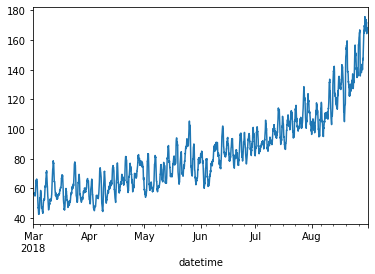

In [12]:
decomposed.trend.plot();

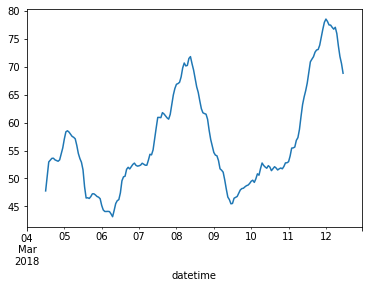

In [13]:
decomposedWeek.trend.plot();

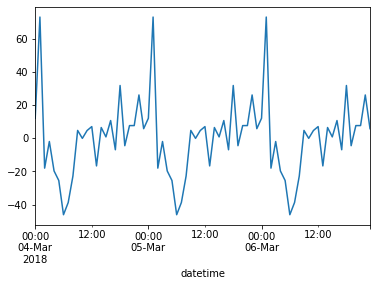

In [14]:
decomposedFewDays.seasonal.plot();

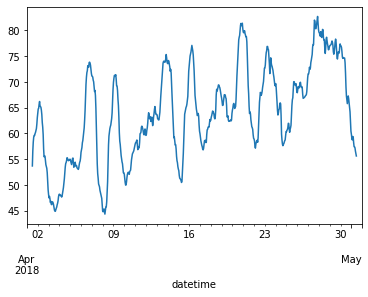

In [15]:
decomposedMonth_apr.trend.plot();

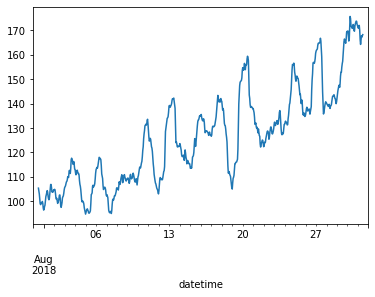

In [16]:
decomposedMonth_aug.trend.plot();

<h3>Анализ трендов и сезонности</h3>
<br>
Рассмотрели тренды:
<br>
1)Всего датасета - и заметили ,что в летний период количество заказов растет , что вполне понятно ,ибо люди предпочитают лишний раз находится по кондиционером ,чем варится на улицу , либо даже водители своих личных авто не прочь лишний раз заказать такси , ибо их машина может стоять под солнечным местом и никто не хочет из нас мучаться)
<br>
<br>
2)Недели из датасета -  для примера взяли начало недели 5 марта 2018 года (понедельник) и 11 марта 2018 года как конец недели (воскресенье) , и заметили ,что можно отметить тенденцию слабого спроса в такие дни как : вторник , суббота и воскресенье . В выходные людям не куда спешить , и дел меньше куда надо ездить ,либо как правило в больших городах люди чаще уезжают за город / на дачу и не нуждаются в такси. Вторник на самом деле для меня остается загадкой почему там так мало заказов, но в гугле нашел и поспрашивая людей ,что день стараются избежать по религиозным причинам , а также сложились стереотипы и суеверия ,что вторник должен быть пустым днем
<br>
<br>
3)2 различных месяцев на фоне общего тренда - это апрель и август , в обоих месяцах наблюдаем такую же ситуацию по дням неделям ,что и в предыдущем анализе (2), А также можно добавить , что к концу каждого месяца ,относительного общего роста , увеличивается число заказов , просто летом этот рост намного значительнее ,чем весной
<br>
<br>
Также рассмотрели сезонность по часам ,где можно отметить ,что с утра самые плохие показатели заказов такси и ситуация начинает улучшаться только после 6 утра и ближе к 12 приходит в примерно стандартное положение с относительными колебаниями ,но пближе к полуночи случается резкий скачок и все едут видимо либо с поздней работы , а что более вероятней - тусить в разные места и присто отдыхать в ночную жизнь,либо наоборот возвращаться в нее)

In [17]:
def make_features(df, max_lag, rolling_sum_size):
    #calendar features
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    #lag feature
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    #rolling feature
    df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_sum_size).mean()

Фактор месяца исходя из общего тренда играет роль ,ибо месяцы лета имеют тренд более высокого роста относительно весенних<br>
Фактор дня играет также роль так как имеет тенденцию также относительно месяца расти с течением времени<br>
Фактор дня недели играет одну из самых важных ролей ,ибо данные исходя из него сильно варьируются<br>
Фактор часа играет самую важную роль ,так как у нас прогнозирование на час вперед также на его фоне выделили сезонность ,где есть очень важные часы пиков и минимумов<br>
Фактор lag нужен для определения интервала на котором обучается модель из целевого признака исходя из желаемого горизонта (если ресампл на день , а прогноз строим на неделю вперед ,то lag(7))  в нашем случае прогноз на час вперед ,то берем и lag(1)<br>
Фактор rolling еще более темный лес чел lag ,но в моем понимании это в чем-то схожий признак с lag ,но как агрегирующая его функция также полезная для прогнозирования , его параметр не очень понимаю как подбирается, но в данном коротком прогнозировании думаю ,что также должен быть минимальным и равным 2

In [ ]:
make_features(df, 24 , 4)

После ресемплинга анализировали тренды, и временной ряд на стационарность ,которую подкорректровали помощью разницы ,вычитая предыдущее
написали функцию для подготовки признаков для будущего обучения модели , где выделили календарные признакми: год , месяц , день , день недели , и час(так как ресемплинг идет по часам). Также добавили и другие признаки: отстающие значения и скользящее среднее , со смещением ,чтобы не было подсматривания данных

# 3. Обучение

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [20]:
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

<h3>Linear Regression</h3>

In [21]:
modelLR = LinearRegression()
modelLR.fit(train_features, train_target)
predictionLR = modelLR.predict(test_features)
mean_squared_error(test_target,predictionLR)**0.5

45.81094888906945

<h3>Cat Boost</h3>

In [22]:
train_dataset = cat.Pool(train_features, train_target)
test_dataset = cat.Pool(test_features, test_target)

In [23]:
modelCat = CatBoostRegressor( random_state = 42)

In [24]:
param_search = {'depth' : [3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'iterations' : [1000, 2000],
                'verbose' : [False]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearchCat = GridSearchCV(estimator=modelCat, cv=tscv,
                        param_grid=param_search,scoring = 'neg_root_mean_squared_error')
gsearchCat.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x1a219c55d0>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [3, 6, 10], 'iterations': [1000, 2000],
                         'learning_rate': [0.03, 0.1], 'verbose': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [25]:
#because of the negate we need to take absolute value
np.abs(gsearchCat.best_score_)

24.15557678635299

In [26]:
gsearchCat.best_params_

{'depth': 6, 'iterations': 2000, 'learning_rate': 0.03, 'verbose': False}

<h3>LightGBM</h3>

In [27]:
modelLight = LGBMRegressor(random_state = 42)
param_search = {'depth' : [-1,3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'n_estimators' : [100,200,1000]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearchLight = GridSearchCV(estimator=modelLight, cv=tscv,
                        param_grid=param_search,scoring = 'neg_root_mean_squared_error')
gsearchLight.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [-1, 3, 6, 10], 'learning_rate': [0.03, 0.1],
                         'n_estimators': [

In [28]:
np.abs(gsearchLight.best_score_)

24.892425814590975

In [29]:
gsearchLight.best_params_

{'depth': -1, 'learning_rate': 0.03, 'n_estimators': 200}

<h3>XGBoost

In [30]:
modelXGB = XGBRegressor(random_state = 42)
param_search = {'max_depth' : [3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'n_estimators' : [1000, 2000]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearchXGB = GridSearchCV(estimator=modelXGB, cv=tscv,
                        param_grid=param_search,scoring = 'neg_root_mean_squared_error')
gsearchXGB.fit(train_features, train_target)

[11:01:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=42,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.03, 0.1], 'max_depth': [3,

Не совсем понял предупреждения ,но думаю ,что метрика просто для нее необчная , вот и ругается)

In [31]:
np.abs(gsearchXGB.best_score_)

24.82692976380582

In [32]:
gsearchXGB.best_params_

{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 1000}

# 4. Тестирование

In [33]:
modelCat = CatBoostRegressor(depth = 6, iterations = 2000, learning_rate = 0.03, loss_function = 'RMSE')
modelCat.fit(train_dataset, eval_set = test_dataset, plot = True, verbose = False);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [34]:
mean_squared_error(test_target, modelCat.predict(test_features))**0.5
prediction = modelCat.predict(test_features)

In [35]:
modelLight = LGBMRegressor(depth = -1,n_estimators = 200, learning_rate = 0.03, random_state = 42)
modelLight.fit(train_features,train_target, eval_set = (test_features,test_target), eval_metric = 'RMSE', verbose = 10);

[10]	valid_0's rmse: 72.5262	valid_0's l2: 5260.05
[20]	valid_0's rmse: 64.2718	valid_0's l2: 4130.86
[30]	valid_0's rmse: 58.2176	valid_0's l2: 3389.29
[40]	valid_0's rmse: 53.9772	valid_0's l2: 2913.54
[50]	valid_0's rmse: 50.7778	valid_0's l2: 2578.38
[60]	valid_0's rmse: 48.5291	valid_0's l2: 2355.08
[70]	valid_0's rmse: 46.8864	valid_0's l2: 2198.34
[80]	valid_0's rmse: 45.5346	valid_0's l2: 2073.4
[90]	valid_0's rmse: 44.5065	valid_0's l2: 1980.83
[100]	valid_0's rmse: 43.9461	valid_0's l2: 1931.26
[110]	valid_0's rmse: 43.4538	valid_0's l2: 1888.23
[120]	valid_0's rmse: 42.8911	valid_0's l2: 1839.64
[130]	valid_0's rmse: 42.4096	valid_0's l2: 1798.58
[140]	valid_0's rmse: 42.0393	valid_0's l2: 1767.3
[150]	valid_0's rmse: 41.7416	valid_0's l2: 1742.36
[160]	valid_0's rmse: 41.4915	valid_0's l2: 1721.54
[170]	valid_0's rmse: 41.3329	valid_0's l2: 1708.41
[180]	valid_0's rmse: 41.2221	valid_0's l2: 1699.27
[190]	valid_0's rmse: 41.1826	valid_0's l2: 1696.01
[200]	valid_0's rmse: 4

In [36]:
mean_squared_error(test_target, modelLight.predict(test_features))**0.5

41.00988569436097

In [37]:
modelXGB = XGBRegressor(max_depth = 3, n_estimators = 1000, learning_rate = 0.03,random_state = 42)
modelXGB.fit(train_features, train_target, eval_set = [(train_features, train_target),(test_features, test_target)], eval_metric = 'rmse', verbose = 10);

[11:14:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:84.6578	validation_1-rmse:147.948
[10]	validation_0-rmse:65.1012	validation_1-rmse:122.61
[20]	validation_0-rmse:51.2361	validation_1-rmse:103.194
[30]	validation_0-rmse:41.5792	validation_1-rmse:89.0527
[40]	validation_0-rmse:35.0252	validation_1-rmse:78.6465
[50]	validation_0-rmse:30.6542	validation_1-rmse:70.5427
[60]	validation_0-rmse:27.7831	validation_1-rmse:64.8437
[70]	validation_0-rmse:25.9584	validation_1-rmse:59.7615
[80]	validation_0-rmse:24.793	validation_1-rmse:56.4338
[90]	validation_0-rmse:23.9303	validation_1-rmse:53.4476
[100]	validation_0-rmse:23.3659	validation_1-rmse:51.5511
[110]	validation_0-rmse:22.9247	validation_1-rmse:49.7697
[120]	validation_0-rmse:22.5691	validation_1-rmse:48.5186
[130]	validation_0-rmse:22.2691	validation_1-rmse:47.5369
[140]	validation_0-rmse:22.0185	validation_1-rmse:46.7824
[150]	validation_0-rmse:21.

In [38]:
mean_squared_error(test_target, modelXGB.predict(test_features))**0.5

42.228906348015535

In [39]:
frame = {'Target':test_target, 'Prediction':prediction}

In [40]:
result = pd.DataFrame(frame) 

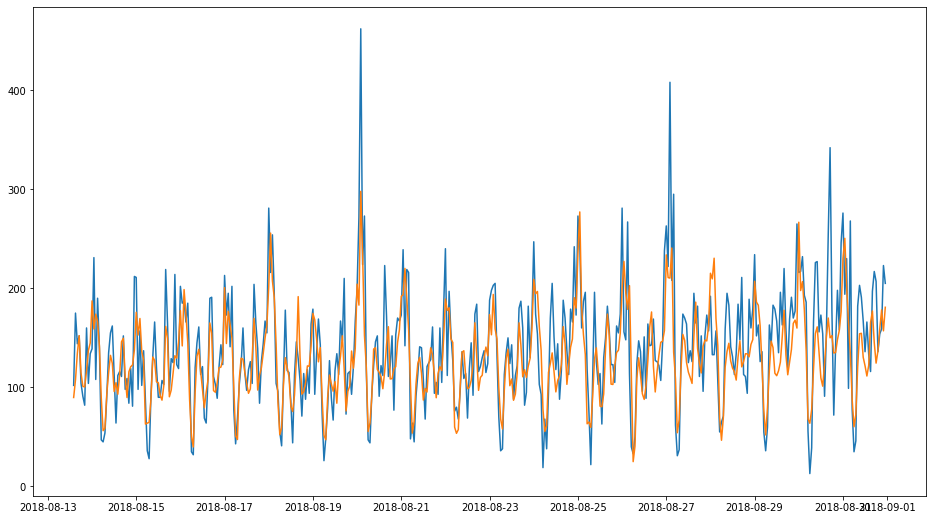

In [41]:
plt.figure(figsize=(16,9))
plt.plot(result);

<h3> Результаты(Target/Prediction):</h3>
<br>
В целом Видно ,что модель в целом неплохо справляется и достаточно хорошо даже предсказывает резкие скачки (например период между 2018-08-19 и 2018-08-21) , а также в целом неплохо повторяет сам target ( лучший период мне кажется с 2018-08-19 по 2018-08-27) ,но также можно отметить ,что модель заметно имеет тенденцию предсказывать ниже target(особенно это видно как раз после 2018-08-27 ,где это видно больше всего) , и совсем редкие исключения ,когда модель переоценила и завысила показатель 

Обучили 3 модели ,которые дали результат на тестовой выборке RMSE < 48 , самой лучшей оказалась CatBoost и на CV , и на тестовой выборке , также неплохо себя показала XGBoost ,которая показала результаты лучше LightGBM. Брали метрику RMSE с отрицательным значением , для поиска минимума , так как по умолчанию функция пытается найти максимум ,поэтому брал модуль , но немного смутило очень малое значение ( есть подозрение в некорректности GridSearchCV и вследствие переобучение ) и такая большая разница на тестовой выборке , но возможно это специфика временных рядов(или специального вида кросс валидации для временных рядов) , ведь мы пытались сделать их более стационарными , но по графикам мне кажется удалось сделать это только со средним значением ,но стандартное отклонение не так сильно и изменилось(если честно, не заметил вообще сущесвтенной разницы) А так как в нашем случае тенденция  к августу/сентябрю растет и модели сложнее предсказать такое будущее